## Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) are a class of deep learning models particularly well-suited for image and sequential data processing. In this project, we leverage CNNs to build a predictive model for diabetes detection based on a structured dataset.

The model architecture includes multiple convolutional layers, pooling layers, and fully connected layers, which help in capturing the patterns and relationships in the input data. Below, we outline the steps involved in building, training, and evaluating our CNN model.

In [40]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,  cross_val_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

## Handling Missing Values

Handling missing values is a critical step in the data preprocessing phase. Missing data can lead to biases in the model and inaccurate predictions if not properly managed. In this section, we identify and handle missing values within our dataset, ensuring that our data is clean and ready for further analysis and model building.

In [2]:
# Load the cleaned dataset
data = pd.read_csv('cleaned_diabetes_dataset.csv')

# Handle missing values in 'gender'
data['gender'] = data['gender'].fillna(data['gender'].mode()[0])

In [4]:
# Prepare the feature set (X) and the target variable (y)
log_cols = ['log_bmi', 'log_HbA1c_level', 'log_blood_glucose_level']
X = data[log_cols + ['gender', 'smoking_history', 'hypertension', 'heart_disease']]
y = data['diabetes']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)


## Model Architecture

The architecture of our CNN model includes the following key components:

- **Convolutional Layers:** Two 1D convolutional layers with ReLU activation, which help in extracting features from the input data.
- **Max Pooling Layers:** Reduce the dimensionality of the data, retaining only the most important features.
- **Flatten Layer:** Converts the pooled feature map into a single vector that can be passed to the fully connected layers.
- **Fully Connected Layers:** Dense layers with ReLU activation to combine the features and make predictions.
- **Dropout Layer:** Added to prevent overfitting by randomly dropping neurons during training.
- **Output Layer:** A softmax layer with two neurons, corresponding to the binary classification task (diabetes vs. no diabetes).

The summary of the model architecture is displayed below.

In [5]:
# Define the focal loss function
def focal_loss(gamma=1.5, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        cross_entropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-cross_entropy)  # Prevents nans when probability is 0
        focal_loss = alpha * (1 - pt) ** gamma * cross_entropy
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

# Updated CNN Model Architecture for Initial Training
model = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model with a lower learning rate and focal loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=focal_loss(gamma=1.5, alpha=0.25),
    metrics=['accuracy']
)

e:\Tabusa School\Banana FYP\ODL\ODL_CODE 3\ODL_CODE\odl_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

We train the CNN model using the training data over a specified number of epochs. Early stopping is implemented to prevent overfitting by halting training when the validation loss stops improving.

The training process involves multiple iterations (epochs), where the model adjusts its internal parameters to minimize the loss function. The progress of the model's accuracy and loss over time is plotted to visualize its learning process.

In [6]:

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Adjusted class weights to improve recall for "Diabetes"
class_weights = {0: 1, 1: 4}  # Adjusted class weight

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights
)


Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8088 - loss: 0.3559 - val_accuracy: 0.9621 - val_loss: 0.1959
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9513 - loss: 0.1739 - val_accuracy: 0.9638 - val_loss: 0.0919
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9597 - loss: 0.0822 - val_accuracy: 0.9649 - val_loss: 0.0422
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9638 - loss: 0.0411 - val_accuracy: 0.9657 - val_loss: 0.0239
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9641 - loss: 0.0262 - val_accuracy: 0.9650 - val_loss: 0.0171
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9664 - loss: 0.0201 - val_accuracy: 0.9677 - val_loss: 0.0137
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9673 - loss: 0.0170 - val_accuracy: 0.9678 - val_loss: 0.0121
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9684 - loss: 0.0154 - 

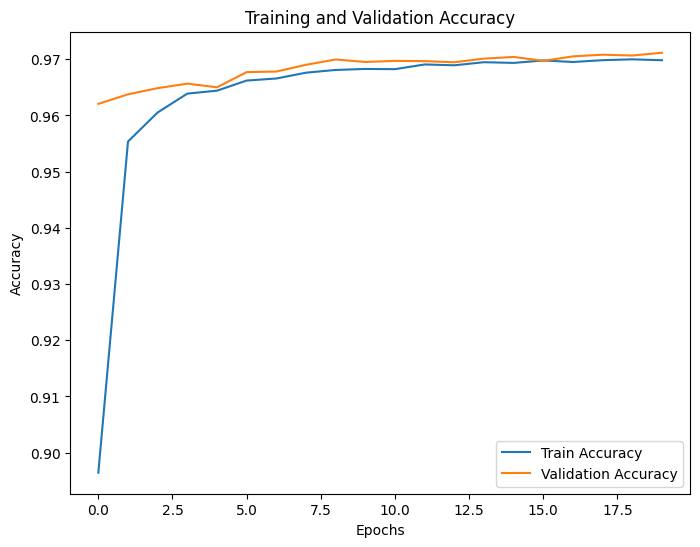

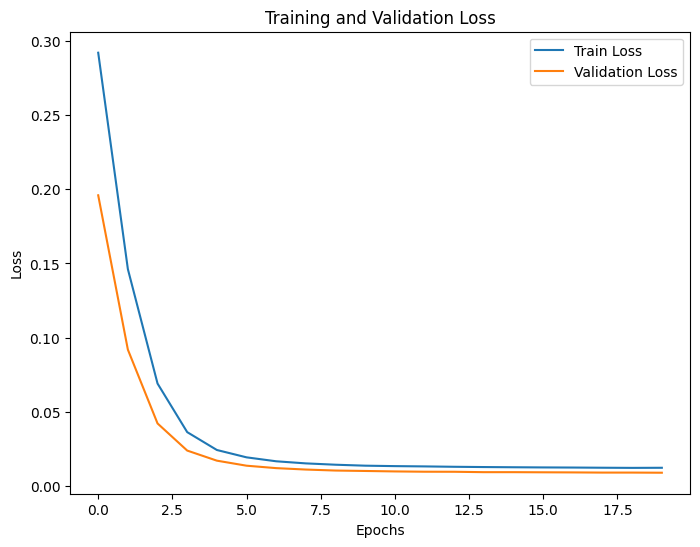

In [7]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Predict on the test data with a custom threshold
y_pred_probs = model.predict(X_test)
threshold = 0.3  # Experiment with lower thresholds
y_pred_classes = (y_pred_probs[:, 1] >= threshold).astype(int)
y_true = np.argmax(y_test, axis=1)

# Evaluate the model on the test data to get accuracy and loss
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the validation accuracy and loss
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step
Validation Accuracy: 97.11%
Validation Loss: 0.0090


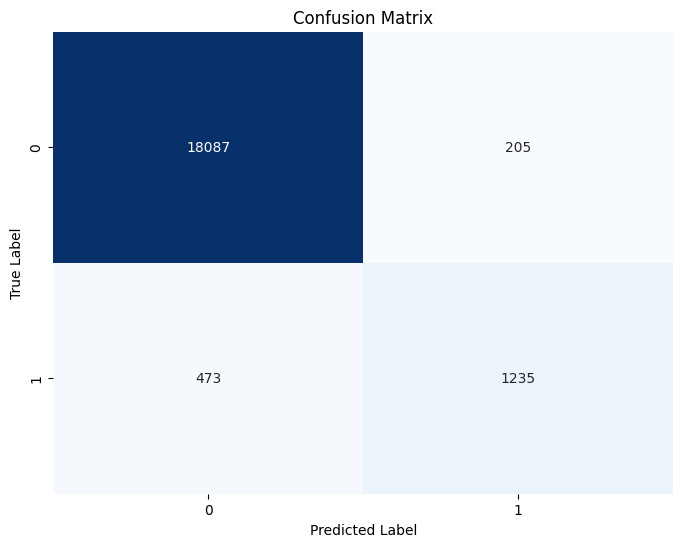

Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.97      0.99      0.98     18292
    Diabetes       0.86      0.72      0.78      1708

    accuracy                           0.97     20000
   macro avg       0.92      0.86      0.88     20000
weighted avg       0.96      0.97      0.96     20000



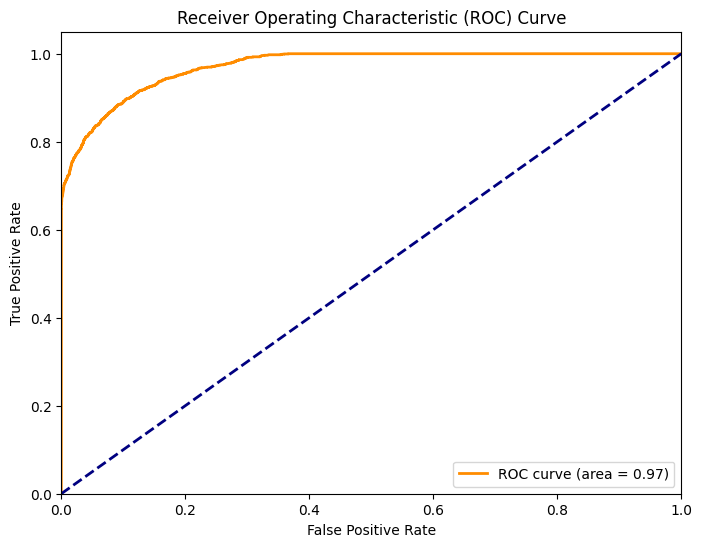

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report:\n", report)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning

To optimize the model's performance, we conduct hyperparameter tuning using Keras Tuner. This process involves searching for the best combination of hyperparameters, such as the number of filters, kernel size, dense units, dropout rate, and learning rate. The best model configuration is selected based on the highest validation accuracy.

In [34]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv1D(
        filters=hp.Int('filters_1', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[2, 3, 5]),
        activation='relu',
        input_shape=(X_train.shape[1], 1),
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Second Convolutional Layer
    model.add(layers.Conv1D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[2, 3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Third Convolutional Layer (Add Only If Dimension is Large Enough)
    current_dim = X_train.shape[1] // 4  # Estimated size after two pooling layers
    if current_dim > 2:
        model.add(layers.Conv1D(
            filters=hp.Int('filters_3', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_3', values=[2, 3]),
            activation='relu',
            padding='same'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Flatten Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(
        units=hp.Int('dense_units_1', min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_regularization_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_regularization_2', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.1)))

    # Output Layer
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=3,
    directory='cnn_hyperparameter_tuning',
    project_name='diabetes_detection_v2'
)

# Run the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, class_weight=class_weights)

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the summary of the best model
best_model.summary()
print(f"Best Hyperparameters: {best_hyperparameters.values}")

Reloading Tuner from cnn_hyperparameter_tuning\diabetes_detection_v2\tuner0.json


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 256)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,450 (1.12 MB)

 Trainable params: 291,426 (1.11 MB)

 Non-trainable params: 1,024 (4.00 KB)

Best Hyperparameters: {'filters_1': 256, 'kernel_size_1': 3, 'filters_2': 256, 'kernel_size_2': 3, 'filters_3': 128, 'kernel_size_3': 3, 'dense_units_1': 160, 'l2_regularization_1': 0.0012313493343406048, 'dropout_1': 0.5, 'dense_units_2': 64, 'l2_regularization_2': 4.116761561064486e-05, 'dropout_2': 0.5, 'learning_rate': 0.0005}


## Model Evaluation

After training the CNN model, we evaluate its performance using various metrics:

- **Confusion Matrix:** Visualizes the true positives, true negatives, false positives, and false negatives.
- **Classification Report:** Provides precision, recall, F1-score, and support for each class.
- **ROC Curve and AUC:** The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) summarize the model's ability to distinguish between classes.

These metrics help us assess the effectiveness of the model and identify areas for potential improvement.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Validation Accuracy: 97.19%
Validation Loss: 0.1307


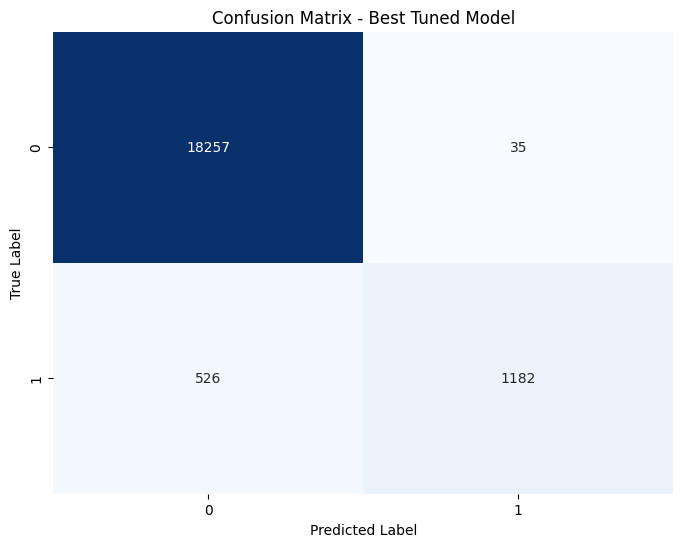

Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.98     18292
    Diabetes       0.97      0.69      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000



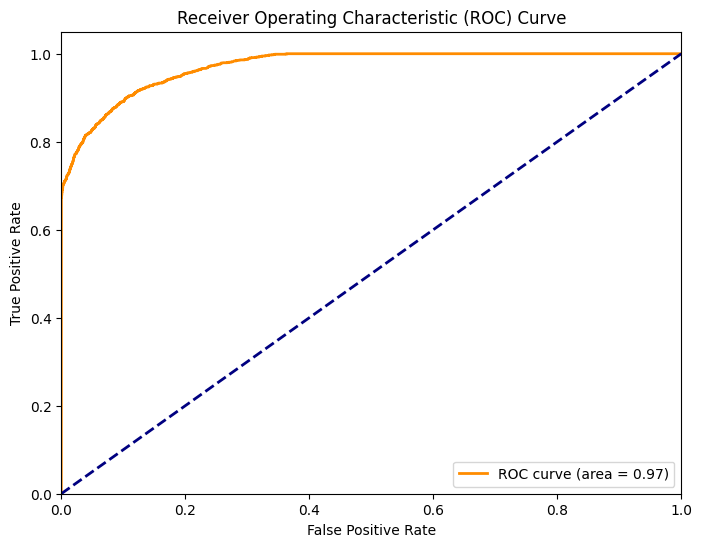

In [36]:
# Predict on the test data with the best tuned model
y_pred_probs = best_model.predict(X_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# Evaluate the model on the test data to get accuracy and loss
val_loss, val_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

# Print the validation accuracy and loss
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Best Tuned Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report:\n", report)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


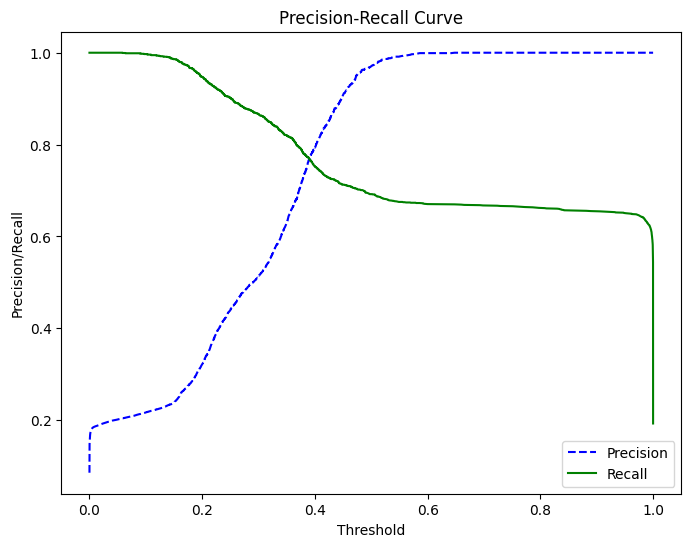

In [37]:
# Predict probabilities on the test set
y_pred_probs = best_model.predict(X_test)

# Calculate precision-recall pairs for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test[:, 1], y_pred_probs[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title("Precision-Recall Curve")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="best")
plt.show()